# LDA

### Referencias

- [Twitter Topic Modeling](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence)
- [Reddit Machine Learning for Topic Analysis](https://machinelearninghd.com/reddit-machine-learning-sentiment-and-topic-analysis/)

In [1]:
import gensim.corpora as corpora
import nltk, spacy, gensim
import pickle
import numpy as np
from gensim.models import CoherenceModel
import pandas as pd
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_lda.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)
    
#print(df['lemma_tokens'])

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

#print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

#print(len(id2word))

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
min_topics = 15
max_topics = 45
step_size = 3
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
result = []

# iterate through number of topics
for a in alpha:
    current = {}

    coherence_values = []
    model_list = []

    # iterate through alpha values
    for k in topics_range:
        # get the coherence score for the given parameters
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=k,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=a,
                                                  per_word_topics=True)

        # Save the model results
        #print('-------------------------------')
        #print('Números de tópicos: ' + str(k))
        #print('Alpha: ' + str(a))

        #print('\nPerplexity: ', lda_model.log_perplexity(corpus))

        coherence_model_lda = CoherenceModel(model=lda_model, texts=df['lemma_tokens'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        #print('\nCoherence Score: ', coherence_lda)

        model_list.append(lda_model)
        coherence_values.append(coherence_lda)


    current['coherence_values'] = coherence_values
    current['model_list'] = model_list
    current['alpha'] = a
    result.append(current)

## Selección del número óptimo de tópicos y *alpha* a través de la medida de coherencia

La puntuación de coherencia parece aumentar con la cantidad de tópicos. No siempre es mejor dónde está el *C_v* más alto, por lo que podemos probar varios para encontrar el mejor resultado. Agregar tópicos puede ayudar a revelar más subtópicos. Sin embargo, si las mismas palabras comienzan a aparecer en varios tópicos, la cantidad de tópicos es demasiado alta.

Se revisaron los resultados de diferentes modelos, comenzando por aquellos que tienen el *C_v* más alto. Debido al acomplamiento entre varios tópicos, se descartaron los primeros dos. El tercero se descarto ya que consideré que tenía pocos tópicos y que el cuarto era más interesante en este sentido. Por lo tanto, se seleccionó como hiperparámetros óptimos el número de tópicos 42 y *alpha* 0.01.


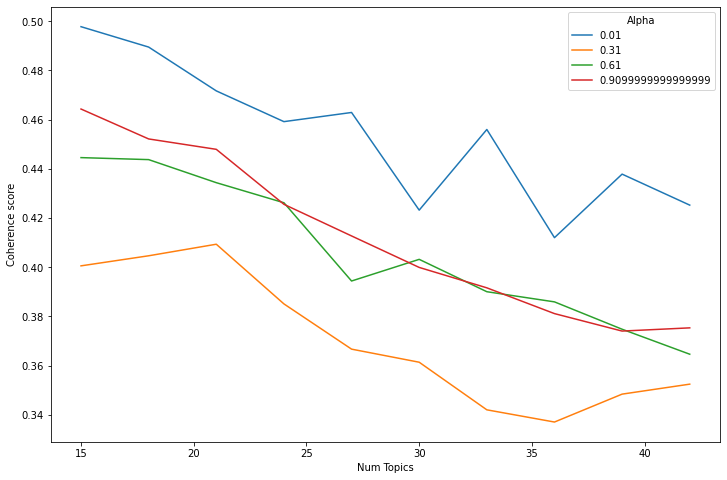

    Alpha  Num Topics  Coherence score
0    0.01          15         0.497816
1    0.01          18         0.489528
2    0.01          21         0.471712
30   0.91          15         0.464335
4    0.01          27         0.462931
3    0.01          24         0.459206
6    0.01          33         0.456012
31   0.91          18         0.452169
32   0.91          21         0.447946
20   0.61          15         0.444575


<Figure size 864x576 with 0 Axes>

In [6]:
plt.figure(figsize=(12, 8))
for current in result:
   plt.plot(topics_range, current['coherence_values'], label=current['alpha'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(title='Alpha', loc='best')
plt.show()

data = []

plt.figure(figsize=(12, 8))
for current in result:
    for index_num_topic, num_topic in enumerate(topics_range):
        data.append([current['alpha'], num_topic, current['coherence_values'][index_num_topic]])

df = pd.DataFrame(data,columns=['Alpha','Num Topics', 'Coherence score'])
df = df.sort_values(by='Coherence score', ascending=False)
print(df.head(10))

In [7]:
# Instantiating a Base LDA model
base_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=15,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=0.01,
                                                  per_word_topics=True)

In [8]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['precio', 'argentino', 'argentina', 'dolar', 'mundo', 'peso', 'inflación', 'país', 'moneda', 'dólares', 'chino', 'subir', 'pagar', 'gobierno', 'millón', 'españa', 'dólar', 'pasar', 'usd', 'pesos', 'provincia', 'venir', 'cambio', 'comprar', 'socialista', 'quilombo', 'impuesto', 'año', 'guerra', 'eeuu']
Topic: 1 
Words: ['gente', 'votar', 'milei', 'voto', 'país', 'partido', 'político', 'él', 'pensar', 'creer', 'pobre', 'gobierno', 'pasar', 'peronismo', 'idea', 'problema', 'vivir', 'ver', 'politico', 'ganar', 'k', 'pueblo', 'paso', 'elección', 'impuesto', 'sacar', 'serio', 'querer', 'tipo', 'hablar']
Topic: 2 
Words: ['foto', 'número', 'llamado', 'llamar', 'salir', 'pasar', 'na', 'jaja', 'amigo', 'hermoso', '️', 'pibe', '😂', 'leche', 'whatsapp', 'vender', 're', 'teléfono', 'pan', 'año', 'saco', 'andar', 'caro', 'seguro', 'gustar', 'san', 'villa', 'kirchner', 'red', 'él']
Topic: 3 
Words: ['pasar', 'año', 'semana', 'él', 'persona', 'decir', 'salir', 'señor', 'vacuna', 'pa

In [9]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.148638 -0.073269       1        1  13.684659
1     -0.134168 -0.090524       2        1  10.911129
9     -0.120069  0.012850       3        1  10.694273
13    -0.085392  0.007342       4        1   7.110496
3     -0.077401  0.011191       5        1   6.656204
4     -0.037213  0.046379       6        1   6.234199
14     0.020048  0.073525       7        1   6.188894
0     -0.027465 -0.123179       8        1   5.931793
11    -0.049900  0.004527       9        1   5.913013
12    -0.008491 -0.075057      10        1   5.637719
10     0.028735  0.094640      11        1   5.306286
2      0.025046  0.115259      12        1   4.810264
8      0.023003  0.034292      13        1   4.560064
7      0.341423 -0.224595      14        1   3.331062
5      0.250480  0.186619      15        1   3.029944, topic_info=         Term        Freq       Total Category  logprob  loglift
402       the  486.000000  486.000000  Default  30.0000  30.0000
34    gracias  483.000000  483.000000  Default  29.0000  29.0000
251      hijo  460.000000  460.000000  Default  28.0000  28.0000
1769    votar  583.000000  583.000000  Default  27.0000  27.0000
275     macri  487.000000  487.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1331      ojo   52.141298  197.771297  Topic15  -5.2240   2.1635
1682     full   37.092300   60.710036  Topic15  -5.5646   3.0039
2491     tele   35.161294   57.702883  Topic15  -5.6180   3.0013
1727     risa   38.372659  115.732005  Topic15  -5.5306   2.3927
476     verde   34.185672   98.790238  Topic15  -5.6462   2.4354

[1008 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
2026       6  0.982964    /r
159       10  0.992588    /s
1225      12  0.958041  1000
11672      6  0.946216  2017
4158       2  0.963915  2021
...      ...       ...   ...
4306      12  0.984379     😂
5243       6  0.955868     🤔
7243       5  0.959370     🤣
7243      15  0.026649     🤣
298       12  0.943626     🤦

[2780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 10, 14, 4, 5, 15, 1, 12, 13, 11, 3, 9, 8, 6])

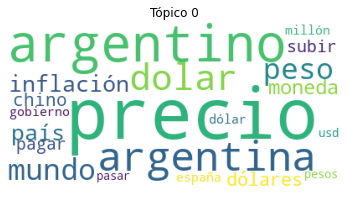

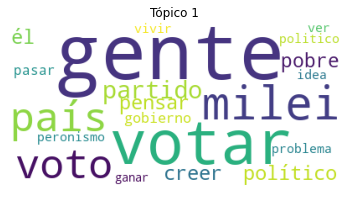

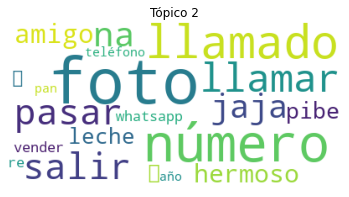

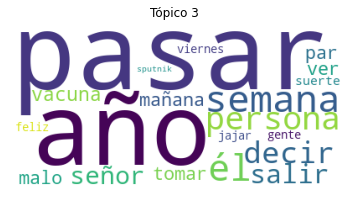

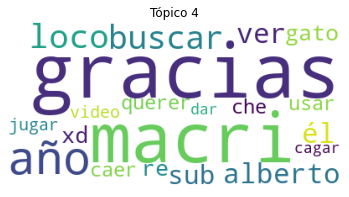

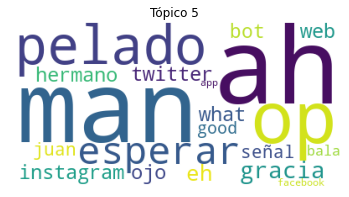

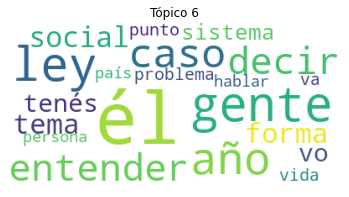

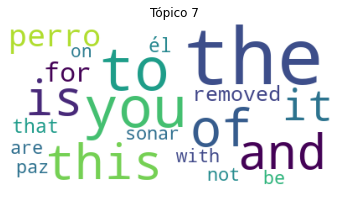

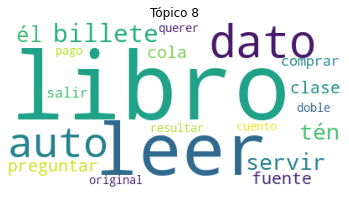

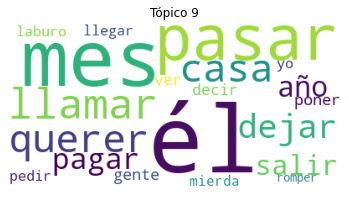

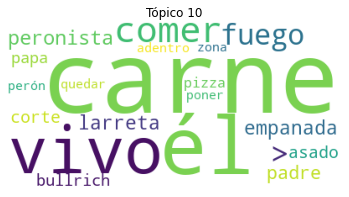

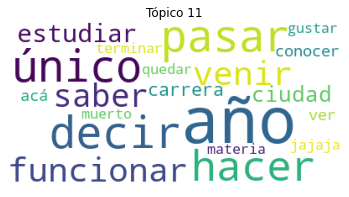

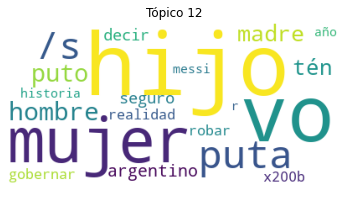

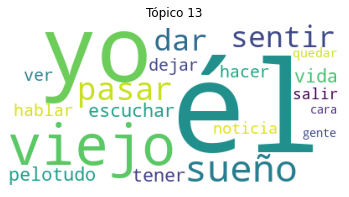

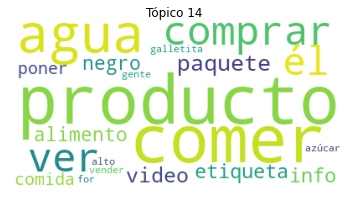

In [10]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(base_model.show_topic(index, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(index))
    plt.show()

In [11]:
reddit = pd.read_csv(TEXT_FILE_READ)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #ent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
                #print(sent_topics_df)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=base_model, corpus=corpus, texts=reddit)

In [12]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,score,id,flair,comms_num,body,comment_parent_id,is_replay
0,0,10.0,0.7114,"carne, él, vivo, comer, >, fuego, peronista, l...",1,hfw14mt,Discusion🧐,1,tapastir baño tirar balde aguo,q44kw3,False
1,1,5.0,0.5833,"ah, man, op, pelado, esperar, gracia, eh, inst...",1,hfw41eh,Discusion🧐,0,sopapa master tapón va teñir medio,hfw14mt,True
2,2,14.0,0.6331,"producto, comer, agua, comprar, ver, él, paque...",1,hfw1ao2,Discusion🧐,0,sopapo tira agua caliente balde,q44kw3,False
3,3,12.0,0.9662,"hijo, vo, mujer, puta, /s, hombre, puto, madre...",1,hfw1wy0,Discusion🧐,0,entender referencia gustar saga,q44kw3,False
4,4,10.0,0.4141,"carne, él, vivo, comer, >, fuego, peronista, l...",1,hfw3jof,Discusion🧐,2,probado resultado sellar boca inodoro tirar ca...,q44kw3,False
5,5,0.0,0.0667,"precio, argentino, argentina, dolar, mundo, pe...",1,hfw4j2w,Discusion🧐,0,soretedx,hfw3jof,True
6,6,8.0,0.5264,"libro, leer, dato, auto, billete, servir, tén,...",1,hfw6v4i,Discusion🧐,0,cobrar mantenimiento carajo kjjjjjjjjj vivirio...,q44kw3,False
7,7,8.0,0.6419,"libro, leer, dato, auto, billete, servir, tén,...",1,hfw26iv,Discusion🧐,0,tén punto metelo fuerza romper tapo baño tirar...,q44kw3,False
8,8,14.0,0.5816,"producto, comer, agua, comprar, ver, él, paque...",1,hfw2gof,Discusion🧐,1,regar jardín tén pod probar,q44kw3,False
9,9,3.0,0.6065,"pasar, año, semana, él, persona, decir, salir,...",1,hfw5s13,Discusion🧐,0,rega jardin lava tenés lavarte mano pulgar chorro,hfw2gof,True


In [13]:
df_dominant_topic.to_csv(TEXT_SAVE_FILE, index=False)